In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import scanpy as sc
# import scvelo as scv

# read the full GSE dataset
adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/batch_corrected/Hao_PBMC_Harmony_unscaled.h5ad')
adata.shape

(161764, 33538)

In [3]:
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(' ', '_')

label = adata.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
print(types)

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


## Read features

In [4]:
# Level 1 ADlasso features by loss difference convergence
import os
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level1/feature_selection')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

In [5]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B,11,6
CD4_T,346,197
CD8_T,22,7
DC,32,15
Mono,19,10
NK,33,17
other,4,2
other_T,59,25


## Get likelihood from LR model

In [6]:
def LR_likelihood_decision_score(data, all_features_dict, celltype):
    print('====================')
    print('Celltype:', celltype)
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    decision_scores = clf.decision_function(X)  # >0: predict celltype, <0: predict not celltype
    print('decision_scores > 0:', sum(decision_scores > 0))

    # calculate the likelihood of the positive class for each observation in X based on the decision scores
    likelihood = 1 / (1 + np.exp(-decision_scores))
    print('likelihood > 0.5:', sum(likelihood > 0.5))  # >0.5: predict celltype, <0.5: predict not celltype
    print(type(likelihood), likelihood.shape)
    #do the row-wise softmax
    # likelihood = np.exp(likelihood)/np.sum(np.exp(likelihood),1,keepdims=True)
    
    return likelihood


def LR_likelihood_pred_prob(data, all_features_dict, celltype):
    print('====================')
    print('Celltype:', celltype)
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # likelihood of the positive class for each observation
    likelihood = clf.predict_proba(X)[:, 1]  # >0.5: predict celltype, <0.5: predict not celltype
    print('likelihood > 0.5:', sum(likelihood > 0.5))  # decision_scores > 0 的有幾個

    return likelihood


In [7]:
celltype = 'B'
B_likelihood = LR_likelihood_pred_prob(adata, features_dict, celltype)
B_likelihood.shape

Celltype: B
likelihood > 0.5: 13754


(161764,)

In [8]:
likelihood_dict = {}
for celltype in types:
    likelihood_dict[celltype] = LR_likelihood_pred_prob(adata, features_dict, celltype)

Celltype: B
likelihood > 0.5: 13754
Celltype: CD4_T
likelihood > 0.5: 40978
Celltype: CD8_T
likelihood > 0.5: 23933
Celltype: DC
likelihood > 0.5: 3535
Celltype: Mono
likelihood > 0.5: 49818
Celltype: NK
likelihood > 0.5: 18593
Celltype: other
likelihood > 0.5: 2441
Celltype: other_T
likelihood > 0.5: 5960


In [9]:
adata.obs['celltype.l1'].value_counts()

celltype.l1
Mono       49010
CD4_T      41001
CD8_T      25469
NK         18664
B          13800
other_T     6789
DC          3589
other       3442
Name: count, dtype: int64

In [10]:
# turn likelihood_dict into dataframe
likelihood_df = pd.DataFrame(likelihood_dict)
likelihood_df.head()

,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
0,0.000011,0.000011,0.000188,2.813255e-05,0.903462,0.000031,0.002287,0.000010
1,0.000024,0.998812,0.020271,2.689498e-09,0.000012,0.000140,0.002949,0.001594
2,0.000057,0.009312,0.999565,1.297607e-09,0.000004,0.000050,0.001976,0.008503
3,0.000036,0.000004,0.004689,1.763011e-09,0.000013,0.999984,0.003752,0.006080
4,0.000025,0.000221,0.998231,4.486027e-10,0.000008,0.000012,0.003492,0.008268


In [11]:
# row sum
likelihood_df.sum(axis=1)


0         0.906028
1         1.023803
2         1.019468
3         1.014558
4         1.010258
            ...   
161759    1.012507
161760    1.002702
161761    1.011120
161762    0.985033
161763    0.962573
Length: 161764, dtype: float64

In [13]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch/Level1/likelihood_UMAP')
likelihood_df.to_csv('L1_likelihood_df.csv')

## (1st_type / 2nd_type) >= 1.5

In [37]:
largest_values = []
second_largest_values = []
largest_columns = []
second_largest_columns = []
odds_ratio_list = []
assignments = []

# for index, row in likelihood_softmax.iterrows():
for index, row in likelihood_df.iterrows():
    # find 1st and 2nd largest values and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    second_largest_value = row.nlargest(2).iloc[-1]
    second_largest_column = row.nlargest(2).index[-1]
    
    largest_values.append(largest_value)
    second_largest_values.append(second_largest_value)
    largest_columns.append(largest_column)
    second_largest_columns.append(second_largest_column)

    # calculate odds ratio
    odds_ratio = largest_value / second_largest_value
    if odds_ratio >= 1.5:
        assign = largest_column
    else:
        assign = 'Uncertain'
    odds_ratio_list.append(odds_ratio)
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns,
                          'Second Largest Value': second_largest_values, 'Second Largest Column': second_largest_columns, 
                          'Odds Ratio': odds_ratio_list, 'Assignment': assignments})
result_df.shape


(161764, 6)

In [38]:
result_df.head(20)

,Largest Value,Largest Column,Second Largest Value,Second Largest Column,Odds Ratio,Assignment
0,0.268419,Mono,0.104696,other,2.563802,Mono
1,0.278682,CD4_T,0.104126,CD8_T,2.676397,CD4_T
2,0.278839,CD8_T,0.103761,CD4_T,2.687309,CD8_T
3,0.279107,NK,0.103758,CD8_T,2.689978,NK
4,0.278274,CD8_T,0.103543,other,2.687516,CD8_T
5,0.197526,CD8_T,0.115211,other_T,1.714464,CD8_T
6,0.276959,Mono,0.103424,other,2.677887,Mono
7,0.279251,B,0.103436,other,2.699742,B
8,0.279075,NK,0.104223,other_T,2.677664,NK
9,0.277877,CD8_T,0.107912,CD4_T,2.575044,CD8_T


In [39]:
sum(result_df['Assignment'] == 'Uncertain')

12915

In [40]:
12915/len(result_df)

0.07983853020449544

## Assign the celltype with the largest likelihood (no odds ratio)

In [14]:
largest_values = []
largest_columns = []
assignments = []
for index, row in likelihood_df.iterrows():
    # find largest value and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    largest_values.append(largest_value)
    largest_columns.append(largest_column)

    assign = largest_column
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns, 'Assignment': assignments})
result_df.shape


(161764, 3)

In [15]:
result_df.head(20)

,Largest Value,Largest Column,Assignment
0,0.903462,Mono,Mono
1,0.998812,CD4_T,CD4_T
2,0.999565,CD8_T,CD8_T
3,0.999984,NK,NK
4,0.998231,CD8_T,CD8_T
5,0.453205,CD8_T,CD8_T
6,0.995247,Mono,Mono
7,0.999967,B,B
8,0.999995,NK,NK
9,0.999852,CD8_T,CD8_T


In [16]:
# count 'uncertain'
sum(result_df['Assignment'] == 'Uncertain')

0

## Confusion heatmap

In [17]:
import pandas as pd

# Get the true labels
true_labels = adata.obs['celltype.l1'].tolist()

# Get the predicted labels
predicted_labels = result_df['Assignment'].tolist()

# Create the confusion matrix
cm = pd.crosstab(true_labels, predicted_labels, rownames=['True'], colnames=['Predicted'], margins=False)

# reorder columns
# cm = cm.reindex(types + ['Uncertain'], axis=1)

# replace NaN with 0
cm = cm.fillna(0)
cm = cm.astype(int)


In [18]:
cm.shape

(8, 8)

In [19]:
cm

Predicted,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
True,,,,,,,,
B,13772,1,3,1,7,3,12,1
CD4_T,1,40534,264,0,2,7,9,184
CD8_T,3,1001,23987,0,0,114,7,357
DC,0,1,0,3395,189,0,2,2
Mono,7,13,8,58,48863,11,49,1
NK,1,15,72,0,1,18524,1,50
other,27,155,54,9,621,34,2490,52
other_T,1,287,646,0,1,180,3,5671


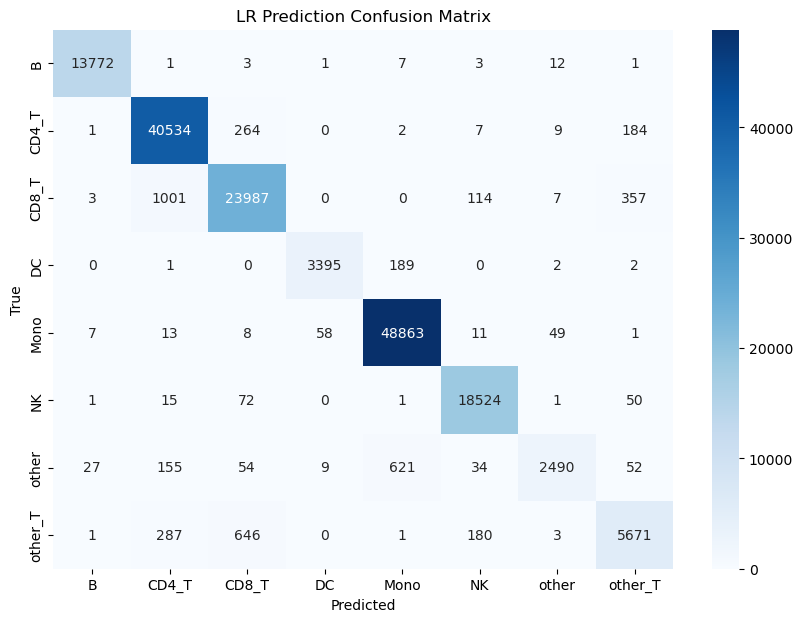

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LR Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [21]:
row_sum = cm.sum(axis=1)
row_sum


True
B          13800
CD4_T      41001
CD8_T      25469
DC          3589
Mono       49010
NK         18664
other       3442
other_T     6789
dtype: int64

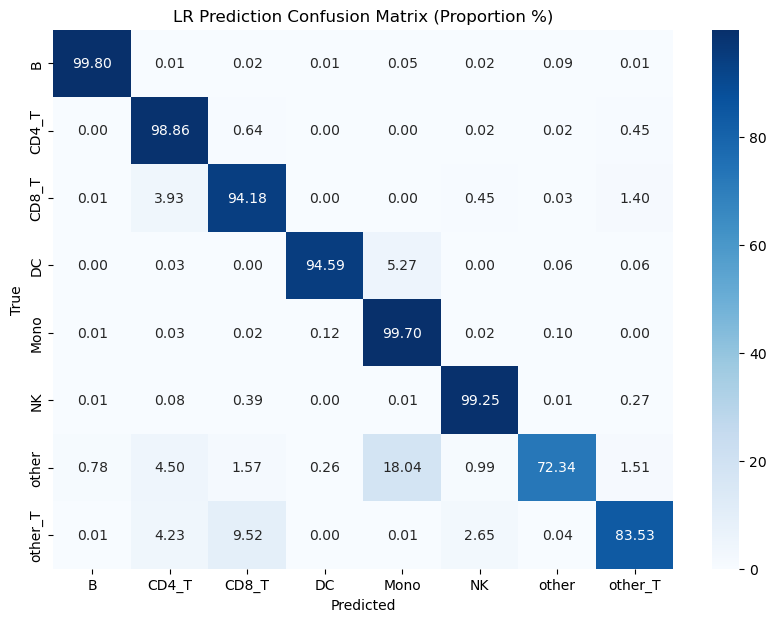

In [22]:
cm_proportion = cm.div(row_sum, axis=0)
cm_proportion *= 100
plt.figure(figsize=(10, 7))
sns.heatmap(cm_proportion, fmt=".2f", annot=True, cmap='Blues')
plt.title('LR Prediction Confusion Matrix (Proportion %)')
plt.show()

## Calculate accuracy

In [23]:
accuracy = sum(np.diag(cm)) / cm.values.sum()
accuracy

0.9720086051284588

In [24]:
cm.values.sum()

161764